**Aerial Cactus Identification** <br>
- 32X32 image
- 선인장 유무 예측 분류기

In [1]:
# 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


In [2]:
train_path = 'dataset/train'
test_path = 'dataset/test'

train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/sample_submission.csv')

In [3]:
train_df['has_cactus'].value_counts()

1    13136
0     4364
Name: has_cactus, dtype: int64

- has_cactus = 1 : 선인장이 있음.
- has_cactus = 0 : 선인장이 없음.
- 선인장이 없는 사진보다 **선인장이 있는 사진이 3배** 많음.

In [4]:
# 이미지 개수 판별
import os

num_train = len(os.listdir(train_path))
num_test = len(os.listdir(test_path))

print(f'train image: {num_train}')
print(f'test iamge: {num_test}')

train image: 17500
test iamge: 4000


- test 이미지 보다 **train 이미지가 4배 더 많음.**
- 이미지의 수가 매우 적다. => 후에 이미지 증강 기법을 사용할 것!

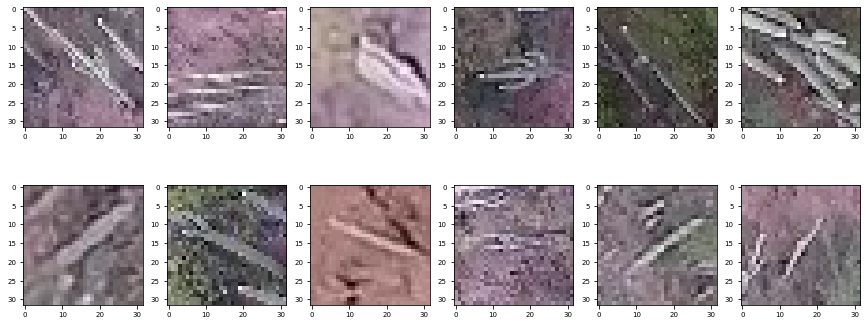

In [5]:
# 이미지 확인
import matplotlib as mpl
import matplotlib.gridspec as gridspec


mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))    # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치(2행 6열로 출력)


label = ['선인장 있음','선인장 없음'] # 타깃 레이블

# 선인장을 포함하는 이미지 파일명(마지막 12개) 
last_has_cactus_img_name = train_df[train_df['has_cactus']==1]['id'][-12:]

# 이미지 출력 
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = 'dataset/train/' + img_name                 # 이미지 파일 경로 
    image = cv2.imread(img_path)                   # 이미지 파일 읽기 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 
    ax = plt.subplot(grid[idx])
    ax.imshow(image) 

In [6]:
image.shape

(32, 32, 3)

- 파일 경로 설정 다시
- https://www.kaggle.com/code/shahules/getting-started-with-cnn-and-vgg16

**CNN 구축하기**
- 고정된 크기(32X32)의 input 필요
- 입력? 3차원 배열
- 컬러 이미지나 그레이 스케일 이미지 모두 항상 depth 보다 width, height의 값이 더 크다.
- input배열을 받아 그 배열의 너비와 높이보다 깊이 값이 훨씬 더 커지는 것을 목표로 함.
- convolution layer : 네트워크를 거침에 따라 깊이값이 증가.
- max pooling later : 면적의 크기를 줄임.
- filter수 : 16->32->64

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras import layers,models
from keras.preprocessing import image
from keras import optimizers
from keras import regularizers

In [8]:
datagen=ImageDataGenerator(rescale=1./255)
batch_size=150

train_df.has_cactus=train_df.has_cactus.astype(str)

train_generator=datagen.flow_from_dataframe(dataframe=train_df[:15001],directory=train_path,x_col='id',
                                            y_col='has_cactus',class_mode='binary',batch_size=batch_size,
                                            target_size=(150,150))


validation_generator=datagen.flow_from_dataframe(dataframe=train_df[15000:],directory=train_path,x_col='id',
                                                y_col='has_cactus',class_mode='binary',batch_size=50,
                                                target_size=(150,150))

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [11]:
model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [14]:
from keras import optimizers
# compile
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
epochs=10
history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=10,validation_data=validation_generator,validation_steps=50)


Epoch 1/10
100/100 [==============================] - 28s 280ms/step - loss: 0.3111 - acc: 0.8557 - val_loss: 0.1542 - val_acc: 0.9412
Epoch 2/10
100/100 [==============================] - 21s 213ms/step - loss: 0.1449 - acc: 0.9453 - val_loss: 0.1623 - val_acc: 0.9352 loss: 0.1460 
Epoch 3/10
100/100 [==============================] - 21s 211ms/step - loss: 0.1275 - acc: 0.9519 - val_loss: 0.1214 - val_acc: 0.9544
Epoch 4/10
100/100 [==============================] - 21s 211ms/step - loss: 0.1143 - acc: 0.9571 - val_loss: 0.1039 - val_acc: 0.9620
Epoch 5/10
100/100 [==============================] - 21s 212ms/step - loss: 0.1096 - acc: 0.9588 - val_loss: 0.0944 - val_acc: 0.9664
Epoch 6/10
100/100 [==============================] - 21s 212ms/step - loss: 0.0891 - acc: 0.9665 - val_loss: 0.1036 - val_acc: 0.9632
Epoch 7/10
100/100 [==============================] - 21s 212ms/step - loss: 0.0800 - acc: 0.9693 - val_loss: 0.0768 - val_acc: 0.9720
Epoch 8/10
100/100 [====================

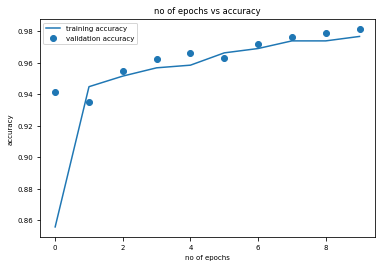

In [17]:
acc=history.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,epochs)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history.history['val_acc']  ##getting validation accuracy of each epochs
plt.scatter(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

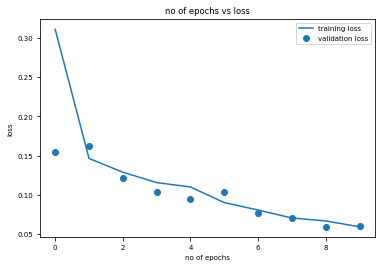

In [19]:
acc=history.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,epochs)    
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history.history['val_loss']  ##getting validation accuracy of each epochs
plt.scatter(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()

### CNN2

In [58]:
model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(256,activation='relu')) # 추가한것
model.add(layers.Dense(1,activation='sigmoid'))

In [59]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_411 (Conv2D)          (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_412 (Conv2D)          (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_413 (Conv2D)          (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_414 (Conv2D)          (None, 15, 15, 128)       147584    
__________

In [60]:
from keras import optimizers
# compile
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

In [61]:
epochs=10
history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=10,validation_data=validation_generator,validation_steps=50)

Epoch 1/10
100/100 [==============================] - 26s 258ms/step - loss: 0.3156 - acc: 0.8542 - val_loss: 0.1575 - val_acc: 0.9480
Epoch 2/10
100/100 [==============================] - 22s 218ms/step - loss: 0.1419 - acc: 0.9467 - val_loss: 0.1412 - val_acc: 0.94966s - loss - ETA: 2s - loss: 0.1392 - 
Epoch 3/10
100/100 [==============================] - 22s 219ms/step - loss: 0.1253 - acc: 0.9520 - val_loss: 0.1440 - val_acc: 0.9544
Epoch 4/10
100/100 [==============================] - 22s 220ms/step - loss: 0.1157 - acc: 0.9561 - val_loss: 0.0945 - val_acc: 0.9648
Epoch 5/10
100/100 [==============================] - 22s 219ms/step - loss: 0.1065 - acc: 0.9591 - val_loss: 0.0948 - val_acc: 0.9660
Epoch 6/10
100/100 [==============================] - 22s 223ms/step - loss: 0.0978 - acc: 0.9643 - val_loss: 0.1010 - val_acc: 0.9600
Epoch 7/10
100/100 [==============================] - 22s 222ms/step - loss: 0.0911 - acc: 0.9655 - val_loss: 0.0811 - val_acc: 0.9744
Epoch 8/10
100/100

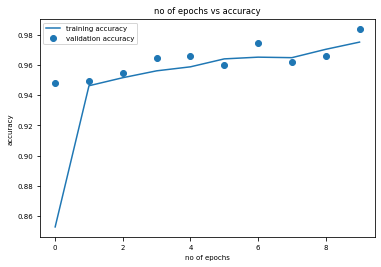

In [62]:
acc=history.history['acc']  ##getting  accuracy of each epochs
epochs_=range(0,epochs)    
plt.plot(epochs_,acc,label='training accuracy')
plt.xlabel('no of epochs')
plt.ylabel('accuracy')

acc_val=history.history['val_acc']  ##getting validation accuracy of each epochs
plt.scatter(epochs_,acc_val,label="validation accuracy")
plt.title("no of epochs vs accuracy")
plt.legend()

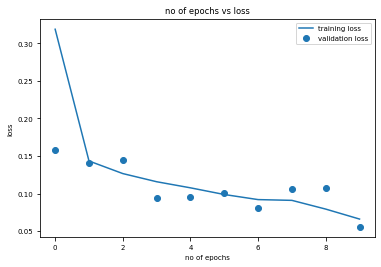

In [63]:
acc=history.history['loss']  ##getting  accuracy of each epochs
epochs_=range(0,epochs)    
plt.plot(epochs_,acc,label='training loss')
plt.xlabel('no of epochs')
plt.ylabel('loss')

acc_val=history.history['val_loss']  ##getting validation accuracy of each epochs
plt.scatter(epochs_,acc_val,label="validation loss")
plt.title("no of epochs vs loss")
plt.legend()